In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

from scipy import optimize

In [3]:
t = Table(fits.getdata('../data/pal5_ls_lite.fits'))

In [6]:
a2ebv = [3.995, 3.214, 2.165, 1.592, 1.211, 1.064]
bands = ['u', 'g', 'r', 'i', 'z', 'Y']

In [39]:
g = 22.5 - 2.5*np.log10(t['flux_g']) - t['ebv'] * a2ebv[1]
r = 22.5 - 2.5*np.log10(t['flux_r']) - t['ebv'] * a2ebv[2]
mask = (np.isfinite(g) & np.isfinite(r) &
        np.isfinite(t['ra']) & np.isfinite(t['dec']) &
        (g < 24.2) & (r < 24.2) & ((g-r) < 1.25))
g = g[mask]
r = r[mask]

c = coord.SkyCoord(ra=t['ra'][mask]*u.deg,
                   dec=t['dec'][mask]*u.deg)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [40]:
X = np.stack((g-r, g)).T
X.shape

(6772909, 2)

In [46]:
cl_pal5 = coord.SkyCoord.from_name('Palomar 5').transform_to(gc.Pal5)

In [41]:
c_pal5 = c.transform_to(gc.Pal5)

In [42]:
phi1 = cpal5.phi1.wrap_at(180*u.deg)
phi2 = cpal5.phi2

(-1.5, 0.5)

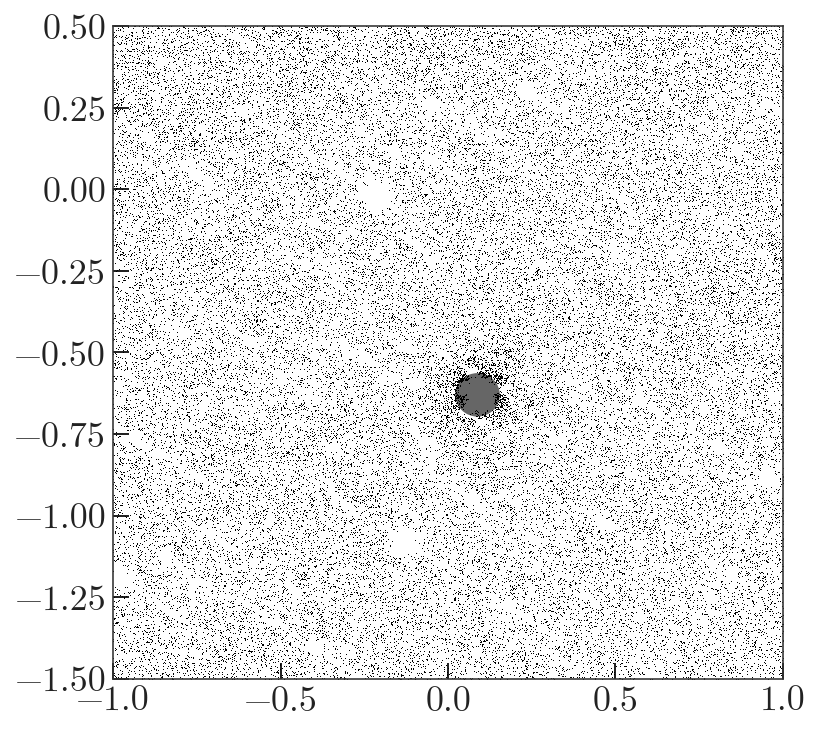

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(phi1.degree, phi2.degree, 
        marker=',', ls='none', alpha=1, color='k')
circ = mpl.patches.Circle((0.088, -0.63), 
                          radius=(3.5*u.arcmin).to_value(u.deg))
ax.add_patch(circ)
ax.set_xlim(-1, 1)
ax.set_ylim(-1.5, 0.5)

In [52]:
sep = cpal5.separation(cl_pal5)
cl_mask = (sep < 12*u.arcmin) & (sep > 3.5*u.arcmin)

In [65]:
iso = Table.read('/Users/adrian/data/Isochrones/MIST/FeH_-1.0_iso.fits')
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]
iso = iso[iso['log10_isochrone_age_yr'] == 10.1]

In [89]:
i_gr = iso['dec_g'] - iso['dec_r']
i_g = iso['dec_g'] + coord.Distance(20*u.kpc).distmod.value

i_left = i_gr - 0.2*(i_g/28)**5
i_right = i_gr + 0.25*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<24) & (poly[:,1]>20.2)
poly_main = poly[ind]
path_main = mpl.path.Path(poly_main)

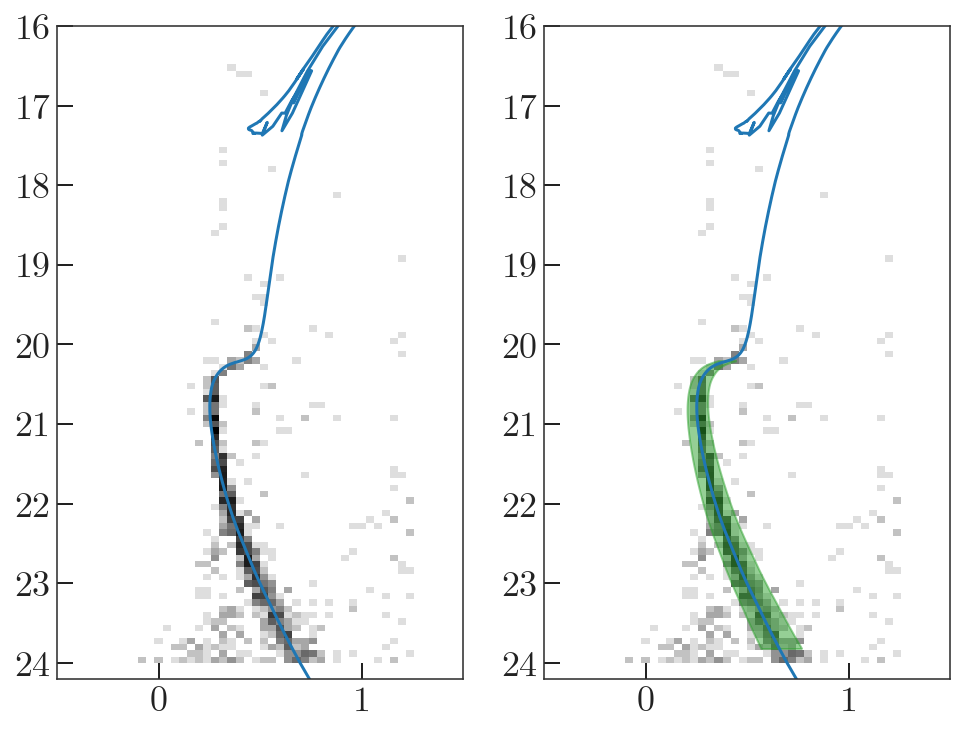

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharex=True)

for ax in axes:
    ax.hist2d(X[cl_mask, 0], X[cl_mask, 1],
              bins=(np.arange(-0.5, 1.5+1e-3, 0.04),
                    np.arange(16, 24.+1e-3, 0.08)),
              cmap='Greys', norm=mpl.colors.LogNorm())

    ax.plot(i_gr, i_g, marker='')

    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(24.2, 16)
    
_p = mpl.patches.Polygon(poly_main, color='tab:green', alpha=0.5)
ax.add_patch(_p)

In [94]:
cl_distmod = coord.Distance(20*u.kpc).distmod.value

In [98]:
# coord.Distance(distmod=cl_distmod + 3)

In [126]:
binsize = 0.1
bins = (np.arange(-20, 15+1e-3, binsize), 
        np.arange(-6, 6+1e-3, binsize))
norm = mpl.colors.Normalize

In [127]:
from scipy.ndimage import gaussian_filter

In [132]:
for i, d in enumerate(np.linspace(10., 32, 128) * u.kpc):
    poly_bin = poly_main.copy()
    poly_bin[:, 1] = poly_bin[:, 1] - cl_distmod + coord.Distance(d).distmod.value
    path = mpl.path.Path(poly_bin)
    
    cmd_mask = path.contains_points(X)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))

    H, xe, ye = np.histogram2d(phi1.degree[cmd_mask], 
                               phi2.degree[cmd_mask],
                               bins=bins)
    H = H.T
    H = gaussian_filter(H, 0.7)
    ax.pcolormesh(xe, ye, np.sqrt(H),
                  cmap='Greys', 
                  norm=norm(vmin=1, vmax=np.sqrt(40)))
    
    
    ax.set_title('$d={:.1f}$ {:latex_inline}'.format(d.value, d.unit))
    ax.set_xlabel(r'$\phi_1$ [deg]')
    ax.set_ylabel(r'$\phi_2$ [deg]')
    fig.tight_layout()
    ax.set_aspect('equal')
    fig.savefig('../plots/pal5_filter_sqrt_{:03d}.png'.format(i), dpi=250)
    plt.close(fig)